In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
import os
import imageio as io
import numpy as np
import tensorflow as tf

from keras import layers 
from keras import metrics
from keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from keras.applications import resnet
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

import warnings
warnings.filterwarnings("ignore")

np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# call 1 sample image to extract image shape
sample_img = data_path + "/train/anchor/10041/1.jpeg" 
input_shape = io.imread(sample_img).shape

In [4]:
# call imageDataGenerator for applying all expected pre-processing on resnet50 
datagen = ImageDataGenerator(preprocessing_function=resnet.preprocess_input)

# generator function for combining Anchor, positive & negative sample in correct order
def multi_input_data_gen(X1_dir, X2_dir, X3_dir, batch_size, seed): 
    genX1 = datagen.flow_from_directory(X1_dir, (input_shape[0], input_shape[1]), batch_size=batch_size, seed=seed, shuffle=False)
    genX2 = datagen.flow_from_directory(X2_dir, (input_shape[0], input_shape[1]), batch_size=batch_size, seed=seed, shuffle=False)
    genX3 = datagen.flow_from_directory(X3_dir, (input_shape[0], input_shape[1]), batch_size=batch_size, seed=seed, shuffle=False)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        X3i = genX3.next()
        yield [X1i[0], X2i[0], X3i[0]]
        
train_dir = data_path + "/train"
val_dir = data_path + "/validation"
test_dir = data_path + "/test"

train_data_gen = multi_input_data_gen(train_dir + "/anchor", train_dir + "/positive", train_dir + "/negative", batch_size, seed)
val_data_gen = multi_input_data_gen(val_dir + "/anchor", val_dir + "/positive", val_dir + "/negative", batch_size, seed)
test_data_gen = datagen.flow_from_directory(directory =  data_path + "/test", target_size = (input_shape[0], input_shape[1]), batch_size = 1, class_mode = None, shuffle = False, seed=seed)

Found 10600 images belonging to 1 classes.


In [5]:
#calculate the number of classes and step size for the dataset

def number_of_data(data_path, dataset):
    
    if dataset != "test":
        dataset_path = data_path + "/" + dataset + "/anchor"
    else:
        dataset_path = data_path + "/" + dataset
    arr1 = os.listdir(dataset_path)
    arr1.sort()
    
    img_number = 0
    if arr1[0] == '.ipynb_checkpoints':
        arr1 = arr1[1:]
    
    for i in range(len(arr1)):
        img_path = dataset_path + "/" + arr1[i]
        arr2 = os.listdir(img_path)
        arr2.sort()
        arr2
        if arr2[0] == '.ipynb_checkpoints':
            arr2 = arr2[1:]
            
        if dataset == "test":
            classes = []
            for i in arr2:
                classes.append(i[0:5])
            class_num = len(set(classes))
        else:
            class_num = len(arr1)            
                
        img_number = img_number + len(arr2)
    return class_num, img_number

num_of_classes, train_step_size = number_of_data(data_path, "train") 
train_step_size = train_step_size//batch_size
    
_ , val_step_size = number_of_data(data_path, "validation") 
val_step_size = val_step_size//batch_size
    
_ , test_step_size = number_of_data(data_path, "test") 
test_step_size = test_step_size//1

In [6]:
# Freeze all resnet50 layers and on-top add in 3 trainable dense layes to construct "Base Model"
resnet_model = resnet.ResNet50(weights="imagenet", input_shape=input_shape, include_top=False)
resnet_model.trainable = False
    
x = layers.GlobalAveragePooling2D()(resnet_model.output)
    
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(emb_size)(x) 

base_model = Model(resnet_model.input, outputs)

anchor_input = layers.Input(shape=input_shape)
positive_input = layers.Input(shape=input_shape)
negative_input = layers.Input(shape=input_shape)

# define a DistanceLayer to calculate the triplet loss
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    
distances = DistanceLayer()(
    base_model(anchor_input),
    base_model(positive_input),
    base_model(negative_input),
    )

model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 768, 3 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1024, 768, 3 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1024, 768, 3 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 256)          26348160    input_2[0][0]                    
                                                                 input_3[0][0]              

In [7]:
# define SiameseModel classes for a custom training and testing loops.

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=margin):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]
    
model = SiameseModel(model)

In [8]:
# Apply Decay learning rate from initial_learning_rate to 0
num_train_steps = train_step_size * max_num_epochs

lr_scheduler = PolynomialDecay(
    initial_learning_rate= initial_learning_rate , end_learning_rate=0.0, decay_steps=num_train_steps
)

#complie model with Adam
model.compile(optimizer = optimizers.Adam(lr_scheduler))

In [9]:
names = "siamese_" + str(num_of_classes) + "classes_" + str(initial_learning_rate) + "margin_" + str(margin) + "alpha_embedding_size_" + str(emb_size)
names

'siamese_53classes_0.0005margin_2alpha_embedding_size_256'

In [10]:
# create the callback and save the weight if a better validation loss is obtained
my_callbacks = [callbacks.ModelCheckpoint(filepath= call_back_save_path + "/models/" + names, monitor='val_loss', mode='auto', save_best_only= True),
                callbacks.CSVLogger(call_back_save_path + "/logger/" + names)]
    
siamese_53classes = model.fit(train_data_gen, steps_per_epoch = train_step_size, epochs= max_num_epochs, validation_data = val_data_gen, validation_steps = val_step_size, shuffle=True, callbacks = my_callbacks)

Found 31800 images belonging to 53 classes.
Found 31800 images belonging to 53 classes.
Found 31800 images belonging to 53 classes.
Epoch 1/30
3975/3975 [==============================] - ETA: 0s - loss: 0.3926Found 10600 images belonging to 53 classes.
Found 10600 images belonging to 53 classes.
Found 10600 images belonging to 53 classes.
3975/3975 [==============================] - 2194s 550ms/step - loss: 0.3926 - val_loss: 0.7736
INFO:tensorflow:Assets written to: ./Model_callback/models\siamese_53classes_0.0005margin_2alpha_embedding_size_256\assets
Epoch 2/30
3975/3975 [==============================] - 2262s 569ms/step - loss: 0.1791 - val_loss: 0.9226
Epoch 3/30
3975/3975 [==============================] - 2317s 583ms/step - loss: 0.1410 - val_loss: 0.3471
INFO:tensorflow:Assets written to: ./Model_callback/models\siamese_53classes_0.0005margin_2alpha_embedding_size_256\assets
Epoch 4/30
3975/3975 [==============================] - 2355s 592ms/step - loss: 0.0996 - val_loss: 0.

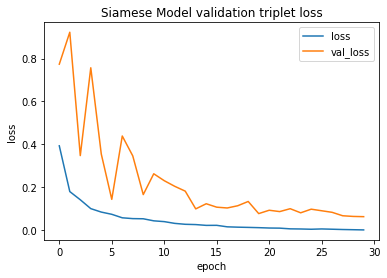

In [12]:
# plot the loss for eaiser evalution
import matplotlib.pyplot as plt

plt.plot(siamese_53classes.history ['loss'])
plt.plot(siamese_53classes.history ['val_loss'])
plt.title('Siamese Model validation triplet loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [13]:
base_model.save(model_save_path + "/" + names + ".h5")

In [15]:
names

'siamese_53classes_0.0005margin_2alpha_embedding_size_256'